[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/langgraph/01-gpt-4o-research-agent.ipynb)

# GPT-4o Research Agent in LangGraph

**Research agents** are multi-step LLM agents that through multiple steps can produce in depth research reports on a topic of our choosing. Most research agents are packed up into their own frameworks, like BlockAGI and others.

In this example, we want to demonstrate how we can build our own AI research agent using `gpt-4o`, Pinecone, LangGraph, arXiv, and Google via the SerpAPI.

In [1]:
# !apt-get install graphviz libgraphviz-dev pkg-config

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


We need these prerequisite libraries to run a graph visualization library (`pygraphviz`). We will use this library during this notebook to understand the structure of our graphs _but_ it is not required to use `langgraph`.

Now we install Python libraries:

In [5]:
# !pip install -qU datasets  langchain-pinecone langchain-openai langchain langchain-core langgraph  semantic-router google-search-results  pygraphviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai 0.65.2 requires appdirs<2.0.0,>=1.4.4, which is not installed.
opentelemetry-exporter-otlp-proto-http 1.27.0 requires deprecated>=1.2.6, which is not installed.
crewai 0.65.2 requires langchain<0.3.0,>=0.2.16, but you have langchain 0.3.3 which is incompatible.
embedchain 0.1.122 requires langchain<=0.3,>0.2, but you have langchain 0.3.3 which is incompatible.
embedchain 0.1.122 requires langchain-openai<0.2.0,>=0.1.7, but you have langchain-openai 0.2.2 which is incompatible.
langchain-cohere 0.1.9 requires langchain-core<0.3,>=0.2.2, but you have langchain-core 0.3.10 which is incompatible.
langchain-community 0.2.17 requires langchain<0.3.0,>=0.2.16, but you have langchain 0.3.3 which is incompatible.
langchain-community 0.2.17 requires langchain-core<0.3.0,>=0.2.39, but you have langchain-core 0.3.10 wh

In [1]:
# !pip install cohere  duckduckgo-search  psycopg2-binary  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.7 MB/s eta 0:00:00a 0:00:01


## Research Agent Overview

Our research agent will consist of a function calling AI agent that has access to several tools that it can use to find information on a particular topic. It will be able to use several tools over multiple steps, meaning it can find information on one topic, broaden the scope of knowledge on this topic and _even_ investigate parallel topics where relevant.

The tools we will be using are:

* **ArXiv paper fetch**: Given an arXiv paper ID, this tool provides our agent with the abstract of the paper.
* **Web search**: This tool provides our agent with access to Google search for more generalized queries.
* **RAG search**: We will create a knowledge base containing AI arXiv papers. This tool provides our agent with access to this knowledge.
* **RAG search with filter**: Sometimes our agent may need more information from a specific paper, this tool allows our agent to do just that.
* **Final answer**: We create a custom final answer tool that forces our agent to output information in a specific format like:

```
INTRODUCTION
------------
<some intro to our report>

RESEARCH STEPS
--------------
<the steps the agent took during research>

REPORT
------
<the report main body>

CONCLUSION
----------
<the report conclusion>

SOURCES
-------
<any sources the agent used>
```

## Setup Knowledge Base

We'll be running our agent against a knowledge base — which requires a Pinecone index to be built.

You can, if needed, skip this step and replace the `search` tool with a placeholder value if wanting to quickly test the structure of a RAG agent _without_ the RAG.

If you want full functionality here, you do need to run this section — but we'll make it quick.

### Download a Dataset

The first thing we need for an agent using RAG is somewhere we want to pull knowledge from. We will use v2 of the AI ArXiv dataset, available on Hugging Face Datasets at [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks).

Note: we're using the prechunked dataset. For the raw version see [`jamescalam/ai-arxiv2`](https://huggingface.co/datasets/jamescalam/ai-arxiv2).

In [1]:
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-semantic-chunks", split="train")
dataset

/home/manish/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['id', 'title', 'content', 'prechunk_id', 'postchunk_id', 'arxiv_id', 'references'],
    num_rows: 209760
})

In [2]:
!which python

/home/manish/miniconda3/envs/lang/bin/python


In [3]:
dataset[0]

{'id': '2401.04088#0',
 'title': 'Mixtral of Experts',
 'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts

Building a knowledge base:

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load the .env file

# Access the variables
api_key = os.getenv('COHERE_API_KEY')
secret = os.getenv('COHERE_API_KEY')

print(f"API Key: {api_key}, Secret: {secret}")


API Key: Vtayqe1h6eGKIs6Ah95jtD5QjLU06cRQDfrrspJC, Secret: Vtayqe1h6eGKIs6Ah95jtD5QjLU06cRQDfrrspJC


In [5]:
import os
from getpass import getpass
from semantic_router.encoders import CohereEncoder

os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY") or getpass("Cohere api key")

encoder = CohereEncoder(name="embed-english-v3.0")

In [8]:
encoder(["some random text"])
# encoder([["some random text"],["some random text"]])

[[-0.020065308,
  -0.018249512,
  -0.02015686,
  0.009536743,
  -0.04837036,
  0.002544403,
  -0.008255005,
  0.005504608,
  0.011001587,
  0.026031494,
  -0.044311523,
  0.049621582,
  -0.03387451,
  0.008560181,
  -0.00333786,
  -0.020004272,
  0.028640747,
  0.047210693,
  0.025024414,
  0.013336182,
  -0.004020691,
  0.02949524,
  -0.055877686,
  -0.0050086975,
  -0.018569946,
  0.02911377,
  0.059173584,
  -0.029846191,
  -0.014640808,
  -0.024337769,
  0.00053167343,
  -0.011306763,
  -0.00065231323,
  0.044769287,
  0.017028809,
  0.035247803,
  0.01309967,
  0.000300169,
  0.010536194,
  0.036315918,
  0.023452759,
  0.010192871,
  -0.017913818,
  0.055908203,
  -0.052825928,
  -0.006000519,
  0.0015974045,
  0.0065460205,
  0.048919678,
  0.036193848,
  0.007007599,
  0.009742737,
  0.0063705444,
  0.0049362183,
  -0.03100586,
  -0.036895752,
  -0.03253174,
  0.064575195,
  0.02330017,
  0.0129470825,
  -0.019485474,
  0.029388428,
  0.013946533,
  -0.02670288,
  0.021194458,


# Setup sqlite vector db

## Redis

In [17]:
import os

REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")
print(f"Connecting to Redis at: {REDIS_URL}")

Connecting to Redis at: redis://localhost:6379


In [18]:
import redis

redis_client = redis.from_url(REDIS_URL)
redis_client.ping()

True

In [5]:
# # In the terminal, download the dataset manually:
# !wget http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz
# !tar -xvzf 20news-bydate.tar.gz


--2024-10-24 19:05:46--  http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz
Resolving qwone.com (qwone.com)... 173.48.205.131
Connecting to qwone.com (qwone.com)|173.48.205.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14464277 (14M) [application/x-gzip]
Saving to: ‘20news-bydate.tar.gz.1’

20news-bydate.tar.g  10%[=>                  ]   1.43M   185KB/s    eta 61s    ^C
20news-bydate-test/
20news-bydate-test/alt.atheism/
20news-bydate-test/alt.atheism/53265
20news-bydate-test/alt.atheism/53339
20news-bydate-test/alt.atheism/53260
20news-bydate-test/alt.atheism/53340
20news-bydate-test/alt.atheism/53333
20news-bydate-test/alt.atheism/53302
20news-bydate-test/alt.atheism/53313
20news-bydate-test/alt.atheism/53293
20news-bydate-test/alt.atheism/53297
20news-bydate-test/alt.atheism/53315
20news-bydate-test/alt.atheism/53320
20news-bydate-test/alt.atheism/53324
20news-bydate-test/alt.atheism/53328
20news-bydate-test/alt.atheism/53325
20news-bydate-test

In [7]:
from sklearn.datasets import load_files

# Point to the extracted local directory
data = load_files("20news-bydate-train", categories=["alt.atheism", "sci.space"])
texts = data.data[:250]
metadata = [{"category": data.target_names[target]} for target in data.target[:250]]

print(len(texts))  # Should output 250


250


In [8]:
# !pip install -qU langchain-core

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-cohere 0.1.9 requires langchain-core<0.3,>=0.2.2, but you have langchain-core 0.3.12 which is incompatible.
langchain-experimental 0.0.65 requires langchain-community<0.3.0,>=0.2.16, but you have langchain-community 0.3.2 which is incompatible.
langchain-experimental 0.0.65 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.12 which is incompatible.


In [9]:
from langchain_core.embeddings import FakeEmbeddings

embeddings = FakeEmbeddings(size=4096)

In [10]:
from langchain_redis import RedisConfig, RedisVectorStore

config = RedisConfig(
    index_name="newsgroups",
    redis_url=REDIS_URL,
    metadata_schema=[
        {"name": "category", "type": "tag"},
    ],
)

vector_store = RedisVectorStore(embeddings, config=config)

In [11]:
ids = vector_store.add_texts(texts, metadata)

print(ids[0:10])

['newsgroups:31d7d8b3266c4817b4a877f1675b6fb9', 'newsgroups:cb9bc7ab9d1247d68277eef0af08f565', 'newsgroups:1fdb3d3e93f445bbb0b019a436b5ad50', 'newsgroups:e65a41b335264e79928db3d23f0efde9', 'newsgroups:868b73f92b7047afb80859dc36402dad', 'newsgroups:53c6ceafade64127a9f5f0065919b6ac', 'newsgroups:64f59a1a8b0d41a1bfe1fbc3b6bdfc66', 'newsgroups:2c5abed01cce4fcda17a43dd4e7252d2', 'newsgroups:983f6cc3558645b3ab177ccd9ed1f6b7', 'newsgroups:74d3a18cc5ae4dcfbb1194bfdcb83a50']


In [12]:
texts[0], metadata[0]

(b'From: gnb@leo.bby.com.au (Gregory N. Bond)\nSubject: Re: Old Spacecraft as NAvigation Beacons!\nIn-Reply-To: nsmca@aurora.alaska.edu\'s message of 21 Apr 93 08:15:55 GMT\nNntp-Posting-Host: leo-gw\nOrganization: Burdett, Buckeridge & Young, Melbourne, Australia\nLines: 17\n\nIn article <1993Apr21.001555.1@aurora.alaska.edu> nsmca@aurora.alaska.edu writes:\n   Other idea for old space crafts is as navigation beacons and such..\n   Why not??\n\nBecause to be any use as a nav point you need to know -exactly- where\nit is, which means you either nail it to something that doesn\'t move\nor you watch it all the time.  Neither of which is possible on a\ndeactivated spacecraft.  Then you have to know exactly how far away\nfrom it you are; this may or may not be possible with the hardware on\nboard. \n\nApart from which, there is absolutely no need for navigation beacons.\n--\nGregory Bond <gnb@bby.com.au> Burdett Buckeridge & Young Ltd Melbourne Australia\n   Knox\'s 386 is slick.          

In [13]:
# Delete documents by passing one or more keys/ids
vector_store.index.drop_keys(ids[0])

1

In [ ]:
# List[List[float]]

In [26]:
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.vectorstores import SQLiteVec

# Create embedding function using a sentence transformer model
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
class embedding_function:
    def embed_query(input:str):
        return encoder([input])[0]
    def embed_documents(input)  :
        return encoder(input)

# Initialize SQLiteVec
db = SQLiteVec(
    table="research_data",
    connection=None,
    db_file="./research_data.db",  # Local SQLite file
    embedding=embedding_function
)


In [29]:
# db.add_texts(["Ketanji Brown Jackson is awesome", "pinaple"])
# # query it again
# query = "fruit"
# data = db.similarity_search(query)

# # print results
# data[0].page_content

'pinaple'

In [ ]:
def ingest_data(texts):
    """Add texts to SQLiteVec vector store."""
    db.add_texts(texts)
    print(f"Added {len(texts)} documents to SQLiteVec.")

# Example Usage: Add some research data
texts = ["AI is transforming industries.", "Cohere offers powerful LLMs."]
ingest_data(texts)


In [ ]:
def query_vector_store(query, k=5):
    """Query the SQLiteVec vector store."""
    results = db.similarity_search(query, k=k)
    return [result.page_content for result in results]

# Example usage
query = "What is Cohere?"
search_results = query_vector_store(query)
for i, result in enumerate(search_results, 1):
    print(f"Result {i}: {result}")


In [ ]:
example  = ()

In [ ]:
db.aadd_documents(vectors=zip(ids, embeds, metadata))

In [ ]:
import time

# index_name = "gpt-4o-research-agent"

# # check if index already exists (it shouldn't if this is first time)
# if index_name not in pc.list_indexes().names():
#     # if does not exist, create index
#     pc.create_index(
#         index_name,
#         dimension=dims,  # dimensionality of embed 3
#         metric='dotproduct',
#         spec=spec
#     )
#     # wait for index to be initialized
#     while not pc.describe_index(index_name).status['ready']:
#         time.sleep(1)

# # connect to index
# index = pc.Index(index_name)
# time.sleep(1)
# # view index stats
# index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 10000}},
 'total_vector_count': 10000}

Populate our knowledge base:

In [32]:
from tqdm.auto import tqdm

# easier to work with dataset as pandas dataframe
data = dataset.to_pandas().iloc[:10000]

batch_size = 2

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    batch = data[i:i_end].to_dict(orient="records")
    # get batch of data
    metadata = [{
        "title": r["title"],
        "content": r["content"],
        "arxiv_id": r["arxiv_id"],
        "references": r["references"].tolist()
    } for r in batch]
    # generate unique ids for each chunk
    ids = [r["id"] for r in batch]
    # get text content to embed
    content = [r["content"] for r in batch]
    # embed text
    # embeds = encoder(content)
    # add to Pinecone
    example = zip(ids, content, metadata)
    break
    # db.aadd_documents(vectors=zip(ids, embeds, metadata))

  0%|          | 0/5000 [00:00<?, ?it/s]


In [34]:
list(example)

[('2401.04088#0',
  '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each

In [38]:
db.add_documents(list(example))

ValueError: Cohere API call failed. Error: list index out of range

In [36]:
query = ('2401.04088#0',
  '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and multilingual benchmarks. We also provide a model fine- tuned to follow instructions, Mixtral 8x7B â Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B â chat model on human bench- marks. Both the base and instruct models are released under the Apache 2.0 license.',
  {'title': 'Mixtral of Experts',
   'content': '4 2 0 2 n a J 8 ] G L . s c [ 1 v 8 8 0 4 0 . 1 0 4 2 : v i X r a # Mixtral of Experts Albert Q. Jiang, Alexandre Sablayrolles, Antoine Roux, Arthur Mensch, Blanche Savary, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Emma Bou Hanna, Florian Bressand, Gianna Lengyel, Guillaume Bour, Guillaume Lample, LÃ©lio Renard Lavaud, Lucile Saulnier, Marie-Anne Lachaux, Pierre Stock, Sandeep Subramanian, Sophia Yang, Szymon Antoniak, Teven Le Scao, ThÃ©ophile Gervet, Thibaut Lavril, Thomas Wang, TimothÃ©e Lacroix, William El Sayed Abstract We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular, Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and multilingual benchmarks. We also provide a model fine- tuned to follow instructions, Mixtral 8x7B â Instruct, that surpasses GPT-3.5 Turbo, Claude-2.1, Gemini Pro, and Llama 2 70B â chat model on human bench- marks. Both the base and instruct models are released under the Apache 2.0 license.',
   'arxiv_id': '2401.04088',
   'references': ['1905.07830']})

In [37]:
# db.add_texts(["Ketanji Brown Jackson is awesome", "pinaple"])
# query it again
# query = "fruit"
data = db.similarity_search(query)

# print results
data[0].page_content

ValueError: Cohere API call failed. Error: status_code: 422, body: data=None message='invalid type: parameter texts is of type array but should be of type string. For proper usage, please refer to https://docs.cohere.com/v1/reference/embed'

## Graph State

We will define a custom graph state to support our agent-oriented decision making.

In [ ]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

There are four parts to our agent state, those are:

* `input`: this is the user's most recent query, usually this would be a question that we want to answer with our research agent.
* `chat_history`: we are building a conversational agent that can support multiple interactions, to allow previous interactions to provide additional context throughout our agent logic we include the chat history in the agent state.
* `intermediate_steps`: provides a record of all steps the research agent will take between the user asking a question via `input` and the agent providing a final answer. This can include things like "search arxiv", "perform general purpose web search", etc. These intermediate steps are crucial to allowing the agent to follow a path of coherent actions and ultimately producing an informed final answer.

## Custom Tools

We will define several tools for this agent that will focus on initial data discovery, that will allow the LLM to use more tools to research more deeply via a variety of different routes.

### ArXiv Paper Fetch

The `fetch_arxiv` tool will allow our agent to get the summary of a specific paper given an ArXiv paper ID. To do this, we will simply send a GET request to arXiv and use regex to extract the paper abstract.

In [ ]:
import requests

# we will test with the mixtral paper
arxiv_id = "2401.04088"

res = requests.get(
    f"https://export.arxiv.org/abs/{arxiv_id}"
)
res.text

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" lang="en">\n<head>\n<title>[2401.04088] Mixtral of Experts</title>\n<link rel="shortcut icon" href="/favicon.ico" type="image/x-icon" />\n<link rel="stylesheet" type="text/css" media="screen" href="/css/arXiv-export.css" />\n<link rel="stylesheet" type="text/css" media="screen" href="/bibex/bibex.css?20181009">\n<link rel="stylesheet" type="text/css" media="screen" href="https://static.arxiv.org/static/browse/0.3.8/css/browse_search.css" />\n<meta name="citation_title" content="Mixtral of Experts" />\n<meta name="citation_author" content="Jiang, Albert Q." />\n<meta name="citation_author" content="Sablayrolles, Alexandre" />\n<meta name="citation_author" content="Roux, Antoine" />\n<meta name="citation_author" content="Mensch, Arthur" />\n<meta name="citation_author" content="Savary

There's a lot going on there. Fortunately, we can use some _relatively_ straightforward regex to find the paper abstract.

In [ ]:
import re

# our regex
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# we search
re_match = abstract_pattern.search(res.text)

# and now let's see what we got
print(re_match.group(1))

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


Now we pack all of this logic into a tool for our agent to use.

In [ ]:
from langchain_core.tools import tool


@tool("fetch_arxiv")
def fetch_arxiv(arxiv_id: str):
    """Gets the abstract from an ArXiv paper given the arxiv ID. Useful for
    finding high-level context about a specific paper."""
    # get paper page in html
    res = requests.get(
        f"https://export.arxiv.org/abs/{arxiv_id}"
    )
    # search html for abstract
    re_match = abstract_pattern.search(res.text)
    # return abstract text
    return re_match.group(1)

Let's test the tool.

In [ ]:
print(
    fetch_arxiv.invoke(input={"arxiv_id": arxiv_id})
)

We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.
Mixtral has the same architecture as Mistral 7B, with the difference that each
layer is composed of 8 feedforward blocks (i.e. experts). For every token, at
each layer, a router network selects two experts to process the current state
and combine their outputs. Even though each token only sees two experts, the
selected experts can be different at each timestep. As a result, each token has
access to 47B parameters, but only uses 13B active parameters during inference.
Mixtral was trained with a context size of 32k tokens and it outperforms or
matches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,
Mixtral vastly outperforms Llama 2 70B on mathematics, code generation, and
multilingual benchmarks. We also provide a model fine-tuned to follow
instructions, Mixtral 8x7B - Instruct, that surpasses GPT-3.5 Turbo,
Claude-2.1, Gemini Pro, and Llama 2 70B - chat model on human benchmarks. Both


### Web Search

The web search tool will provide the agent with access to web search. It will be instructed to use this for more general knowledge queries.

In [ ]:
from serpapi import GoogleSearch

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")
}

search = GoogleSearch({
    **serpapi_params,
    "q": "coffee"
})

results = search.get_dict()["organic_results"]

In [ ]:
contexts = "\n---\n".join(
    ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
)

In [ ]:
print(contexts)

Coffee
Coffee is a beverage brewed from roasted coffee beans. Darkly colored, bitter, and slightly acidic, coffee has a stimulating effect on humans, primarily due ...
https://en.wikipedia.org/wiki/Coffee
---
Starbucks Coffee Company
A carbonated iced drink with tea on top, an iced coffee with a creamy foam. Sunny-day essentials. Flavorful creations ...
https://www.starbucks.com/
---
What is Coffee?
Coffee traces its origin to a genus of plants known as Coffea. Within the genus there are over 500 genera and 6,000 species of tropical trees and shrubs.
https://www.ncausa.org/About-Coffee/What-is-Coffee
---
Peet's Coffee | The Original Craft Coffee, Est. 1966
Since 1966, Peet's Coffee has source and offered superior coffees and teas and adhering to strict high-quality and taste standards. Shop today.
https://www.peets.com/
---
Philz Coffee: Home
We specialize in customized blends with coffee shops in California and Chicago, IL Buy coffee online or find your nearest Philz location.
https:/

We put this process into a tool:

In [ ]:
# @tool("web_search")
# def web_search(query: str):
#     """Finds general knowledge information using Google search. Can also be used
#     to augment more 'general' knowledge to a previous specialist query."""
#     search = GoogleSearch({
#         **serpapi_params,
#         "q": query,
#         "num": 5
#     })
#     results = search.get_dict()["organic_results"]
#     contexts = "\n---\n".join(
#         ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
#     )
#     return contexts

from duckduckgo_search import ddg
@tool("web_search")
def web_search(query: str):
    results = ddg(query, max_results=5)
    contexts = "\n---\n".join(
        [f"{x['title']}\n{x['body']}\n{x['href']}" for x in results]
    )
    return contexts


### RAG Tools

We provide two RAG-focused tools for our agent. The `rag_search` allows the agent to perform a simple RAG search for some information across _all_ indexed research papers. The `rag_search_filter` also searches, but _within_ a specific paper which is filtered for via the `arxiv_id` parameter.

We also define the `format_rag_contexts` function to handle the transformation of our Pinecone results from a JSON object to a readble plaintext format.

In [ ]:
from langchain_core.tools import tool

def format_rag_contexts(matches: list):
    contexts = []
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Content: {x['metadata']['content']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
            f"Related Papers: {x['metadata']['references']}\n"
        )
        contexts.append(text)
    context_str = "\n---\n".join(contexts)
    return context_str

@tool("rag_search_filter")
def rag_search_filter(query: str, arxiv_id: str):
    """Finds information from our ArXiv database using a natural language query
    and a specific ArXiv ID. Allows us to learn more details about a specific paper."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={"arxiv_id": arxiv_id})
    context_str = format_rag_contexts(xc["matches"])
    return context_str

@tool("rag_search")
def rag_search(query: str):
    """Finds specialist information on AI using a natural language query."""
    xq = encoder([query])
    xc = index.query(vector=xq, top_k=2, include_metadata=True)
    context_str = format_rag_contexts(xc["matches"])
    return context_str

### Final Answer

Finally, we define a "final answer" tool. This isn't a tool in the usual sense, instead we use it to force a particular output format from our LLM via the function/tool calling.

In [ ]:
@tool("final_answer")
def final_answer(
    introduction: str,
    research_steps: str,
    main_body: str,
    conclusion: str,
    sources: str
):
    """Returns a natural language response to the user in the form of a research
    report. There are several sections to this report, those are:
    - `introduction`: a short paragraph introducing the user's question and the
    topic we are researching.
    - `research_steps`: a few bullet points explaining the steps that were taken
    to research your report.
    - `main_body`: this is where the bulk of high quality and concise
    information that answers the user's question belongs. It is 3-4 paragraphs
    long in length.
    - `conclusion`: this is a short single paragraph conclusion providing a
    concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
    referenced during the research process
    """
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return ""

## Initialize the "Oracle"

The **Oracle** LLM is our graph's decision maker. It decides which path we should take down our graph. It functions similarly to an agent but is much simpler and reliable.

The Oracle consists of an LLM provided with a set of potential function calls (ie our tools) that it can decide to use — we force it to use _at least_ one of those tool using the `tool_choice="any"` setting (see below). Our Oracle only makes the decision to use a tool, it doesn't execute the tool code itself (we do that seperately in our graph).

### Oracle Prompt

Our prompt for the Oracle will emphasize it's decision making ability within the `system_prompt`, leave a placeholder for us to later insert `chat_history`, and provide a place for us to insert the user `input`.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

Next, we must initialize our `llm` (for this we use `gpt-4o`) and then create the _runnable_ pipeline of our Oracle.

The runnable connects our inputs (the user `input` and `chat_history`) to our `prompt`, and our `prompt` to our `llm`. It is also where we _bind_ our tools to the LLM and enforce function calling via `tool_choice="any"`.

In [ ]:
from langchain_core.messages import ToolCall, ToolMessage
import cohere
co = cohere.Client(os.getenv("COHERE_API_KEY"))

def cohere_embed(texts):
    response = co.embed(model="embed-multilingual-v2.0", texts=texts)
    return response.embeddings

tools=[
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

Test the agent quickly to confirm it is functional:

In [ ]:
inputs = {
    "input": "tell me something interesting about dogs",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)
out

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_UL4qocVvucVLhykCbn1WEkaV', 'function': {'arguments': '{"query": "interesting facts about dogs"}', 'name': 'web_search'}, 'type': 'function'}, {'id': 'call_VeoMlK9MKFopRVLBXAqtnSm2', 'function': {'arguments': '{"query": "interesting facts about dogs"}', 'name': 'rag_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 541, 'total_tokens': 590}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'stop', 'logprobs': None}, id='run-ddd60742-06ec-4b16-bf37-6d5eefa423eb-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_UL4qocVvucVLhykCbn1WEkaV'}, {'name': 'rag_search', 'args': {'query': 'interesting facts about dogs'}, 'id': 'call_VeoMlK9MKFopRVLBXAqtnSm2'}], usage_metadata={'input_tokens': 541, 'output_tokens': 49, 'total_tokens': 590})

It is running but we are returning a lot of output here, we can narrow this down to what we need — ie, the chosen tool name and generated input args for the tool.

In [ ]:
out.tool_calls[0]["name"]

'web_search'

In [ ]:
out.tool_calls[0]["args"]

{'query': 'interesting facts about dogs'}

We can see now that our Oracle decided to use the `web_search` tool with a `query` of `"interesting facts about dogs"` — a good choice.

## Define Nodes for Graph

We will be passing the tool use decision to our `router` which will _route_ the output to the chosen node component to run (we define these below) based on the `out.tool_calls[0]["name"]` value.

In [ ]:
def run_oracle(state: list):
    print("run_oracle")
    print(f"intermediate_steps: {state['intermediate_steps']}")
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "final_answer"

All of our tools can be run using the same function logic, which we define with `run_tool`. The input parameters to our tool call and the resultant output are added to our graph state's `intermediate_steps` parameter.

In [ ]:
tool_str_to_func = {
    "rag_search_filter": rag_search_filter,
    "rag_search": rag_search,
    "fetch_arxiv": fetch_arxiv,
    "web_search": web_search,
    "final_answer": final_answer
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

## Define Graph

In [ ]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search_filter", run_tool)
graph.add_node("rag_search", run_tool)
graph.add_node("fetch_arxiv", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

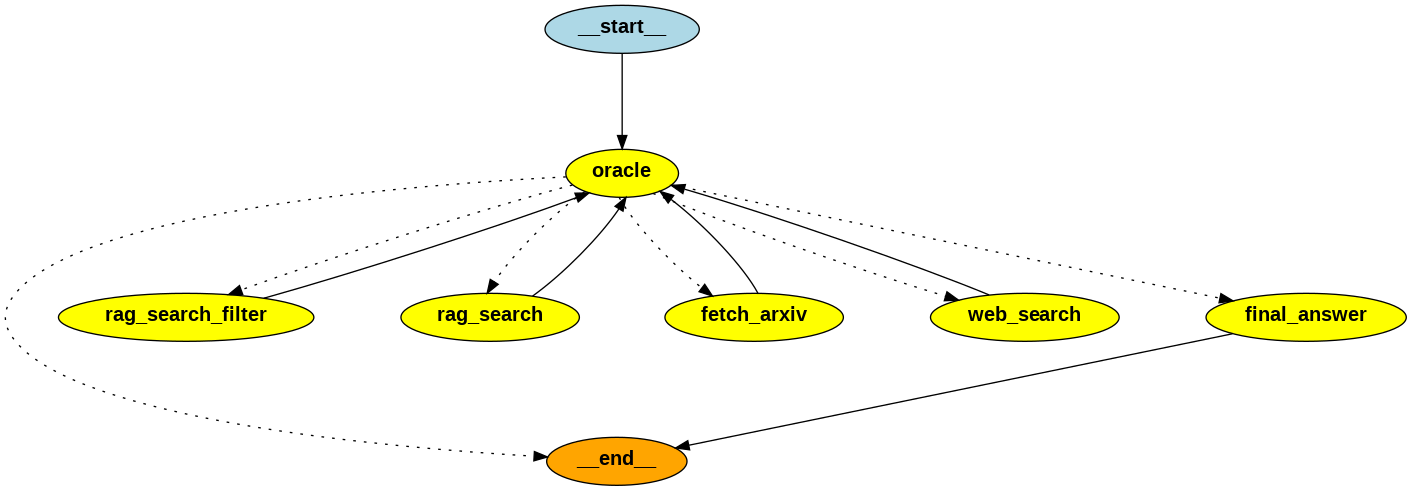

In [ ]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

## Building Reports

Let's test our research agent. First, I want to try on something simple (although not within the intended use-case of our agent):

In [ ]:
out = runnable.invoke({
    "input": "tell me something interesting about dogs",
    "chat_history": [],
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'interesting facts about dogs'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'interesting facts about dogs'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'interesting facts about dogs'}, log="Title: CALYPSO: LLMs as Dungeon Masters' Assistants\nContent: The blink dogs are canine creatures, about the size of a large dog. Their fur is a mottled grey and white colour, and their eyes flash yellow when they use their supernatural ability to blink in and out of ex- istence. They are surprisingly fast despite their size, and can easily keep up with most horses. In terms of behavior, the blink dogs are curious but shy creatures who prefer to avoid contact with other creatures un- less absolutely necessary. If threatened, they will use their blinking power to confuse and disorientate their opponents before attacking with a pack mentality. The blink dogs of this forest 

Let's create a function to consume the agent output and format it into our report:

In [ ]:
def build_report(output: dict):
    research_steps = output["research_steps"]
    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    sources = output["sources"]
    if type(sources) is list:
        sources = "\n".join([f"- {s}" for s in sources])
    return f"""
INTRODUCTION
------------
{output["introduction"]}

RESEARCH STEPS
--------------
{research_steps}

REPORT
------
{output["main_body"]}

CONCLUSION
----------
{output["conclusion"]}

SOURCES
-------
{sources}
"""

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Dogs are fascinating creatures that have been companions to humans for thousands of years. They are known for their loyalty, intelligence, and diverse abilities. Here are some interesting facts about dogs that highlight their unique characteristics and behaviors.

RESEARCH STEPS
--------------
1. Conducted a specialist search on ArXiv for any research papers or articles related to interesting facts about dogs.
2. Performed a web search to gather general knowledge and fun facts about dogs from various reputable sources.

REPORT
------
Dogs were the first animals to be domesticated by humans, with evidence suggesting this occurred over 20,000 years ago. As they evolved from wolves, their physical features such as skulls, teeth, and paws became smaller. Today, there are more than 150 dog breeds, categorized into eight classes: sporting, hound, working, terrier, toy, non-sporting, herding, and miscellaneous.

One of the most remarkable abilities of dogs is their 

Now let's try with an on-topic question on AI.

In [ ]:
out = runnable.invoke({
    "input": "tell me about AI",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'AI'}, log="Title: Cognitive Architectures for Language Agents\nContent: AI-generated characters for supporting personalized learning and well-being. Nature Machine Intelligence, 3(12):1013â 1022, 2021. A. Peng, I. Sucholutsky, B. Li, T. R. Sumers, T. L. Griffiths, J. Andreas, and J. A. Shah. Language guided state abstractions. In Workshop on Social Intelligence in Humans and Robots at RSS 2023, 2023. E. L. Post.\nArXiv ID: 2309.02427\nRelated Papers: ['2305.14909']\n\n---\nTitle: An In-depth Survey of Large Language Model-based Artificial Intelligence Agents\nContent: thoughtsâ together to autonomously achieve whatever goal users set An task-driven autonomous agent leveraging GPT-4 language model, Pinecone vector search, and the LangChain framework to perform

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Artificial Intelligence (AI) is a rapidly evolving field that encompasses a wide range of technologies and applications aimed at simulating human intelligence in machines. From cognitive architectures to large language models, AI is transforming various domains by enabling machines to perform tasks that typically require human intelligence.

RESEARCH STEPS
--------------
1. Conducted a specialist search on AI using the RAG search tool.
2. Retrieved detailed information on specific AI papers and their abstracts.
3. Performed a web search to gather general knowledge and an overview of AI from various reputable sources.

REPORT
------
Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, particularly computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions), and self-correction. AI applic

Let's ask about RAG specifically.

In [ ]:
out = runnable.invoke({
    "input": "what is retrieval augmented generation?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'retrieval augmented generation'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'retrieval augmented generation'}, log="Title: AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation\nContent: Due to the page limit, details of the evaluation, including case studies in three scenarios are in Appendix D. # A2: Retrieval-Augmented Code Generation and Question Answering Retrieval augmentation has emerged as a practical and effective approach for mitigating the intrinsic limitations of LLMs by incorporating external documents. In this section, we employ AutoGen to build a Retrieval-Augmented Generation (RAG) system (Lewis et al., 2020; Parvez et al., 2021) named Retrieval-augmented Chat. The system consists of two agents: a Retrieval-augmented User Proxy agent and a Retri

In [ ]:
print(build_report(
    output=out["intermediate_steps"][-1].tool_input
))


INTRODUCTION
------------
Retrieval-Augmented Generation (RAG) is an advanced technique in the field of artificial intelligence that aims to enhance the performance of generative models by incorporating external information. This method is particularly useful for improving the accuracy and reliability of responses generated by large language models (LLMs).

RESEARCH STEPS
--------------
1. Conducted a specialized search using the RAG search tool to gather detailed information on Retrieval-Augmented Generation.
2. Performed a web search to collect general knowledge and additional perspectives on RAG.
3. Compiled and synthesized the information from both specialized and general sources to provide a comprehensive overview.

REPORT
------
Retrieval-Augmented Generation (RAG) is a framework designed to improve the quality of responses generated by large language models (LLMs) by integrating external information sources. Traditional generative models rely solely on the data they were traine

---